In [2]:
%cd ..

D:\anomaly-detection


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
from src.features.build_features import rolling_window
from src.models.DDRE import *

cf.go_offline(connected=True)

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [8]:
import statsmodels.tsa.api as sm

In [19]:
first_half, second_half = data[:data.shape[0]//2], data[data.shape[0]//2:]

In [84]:
var = sm.VAR(first_half)
res = var.fit(maxlags=15)

In [85]:
forecast = res.forecast(first_half.values[-res.k_ar:], second_half.shape[0])

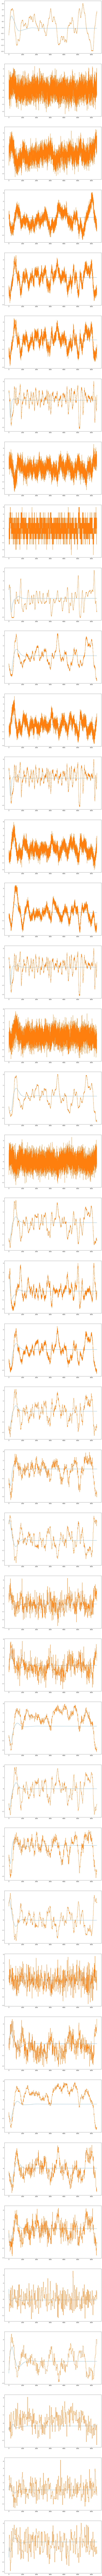

In [86]:
sz = 10
plt.figure(figsize=(15, 10*second_half.shape[1]))
for i in range(second_half.shape[1]):
    plt.subplot(second_half.shape[1], 1, i+1)
    plt.plot(forecast[:, i], linestyle='--')
    plt.plot(second_half.values[:, i])